# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We start with a simple model here:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{cg} & \sim \text{Log-Norm}(0, 1) \\
x_{cgs} \mid \beta_{cg} &  \sim \text{Pois}\left(l_{cgs} \cdot \exp \left(\beta_{cg} \right) \right) \\
\end{align}

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated  data

In [5]:
seed = 42
np.random.seed(seed)

In [29]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [30]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [31]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [32]:
count_table

,genes,conditions,sgrnas,replicates
0,G0,C0,S0,R0
1,G0,C0,S0,R1
2,G0,C0,S1,R0
3,G0,C0,S1,R1
4,G0,C1,S0,R0
5,G0,C1,S0,R1
6,G0,C1,S1,R0
7,G0,C1,S1,R1
8,G1,C0,S0,R0
9,G1,C0,S0,R1


In [9]:
tau_true = sp.stats.halfcauchy.rvs(0, 3, size=1)

In [10]:
gamma_true = sp.stats.norm.rvs(0, tau_true, size=len(genes))

In [11]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true = np.repeat(beta_true, len(sgrnas) * len((replicates)))

In [12]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true = np.repeat(l_true, len(replicates))

In [13]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [15]:
count_table["counts"] = sp.stats.poisson.rvs(
    l_true * np.exp(beta_true))

## Centered Inference in logterm model

In [88]:
tau_true

array([2.00140274])

In [93]:
gamma_true = 4

In [100]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, 3), tau_true)
beta_true

array([3.77603972, 3.34791345, 2.54054583])

In [117]:
l_true = sp.stats.lognorm.rvs(
    .1, size = 3 * 2)
l_true

array([1.00173859, 0.96197751, 1.23664188, 1.12406728, 0.97294174,
       0.91288204])

In [153]:
beta_idx = np.repeat([0, 1, 2], 6 * 5)
beta_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [154]:
l_idx = np.repeat([0, 1, 2, 3, 4, 5], 3 * 5)
l_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [155]:
counts = sp.stats.poisson.rvs(np.exp(beta_true[beta_idx]) * l_true[l_idx])
counts

array([41, 32, 57, 50, 30, 42, 46, 47, 43, 45, 46, 39, 48, 39, 52, 51, 52,
       33, 43, 44, 32, 26, 37, 46, 45, 48, 30, 46, 46, 40, 38, 25, 45, 48,
       38, 36, 26, 39, 38, 29, 37, 39, 42, 40, 34, 32, 25, 41, 35, 31, 32,
       34, 27, 25, 37, 39, 34, 33, 35, 30, 14, 16, 15, 14, 19, 14, 12, 13,
       17, 10, 17, 12,  9,  7, 11, 13, 11, 14, 10, 16,  9, 12, 11,  8, 16,
       12, 13, 11, 14, 10])

In [126]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=1)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta = pm.Normal('beta', gamma[[0, 0, 0]], tau_b[[0, 0, 0]], shape=3)    
    l = pm.Lognormal('l', 0, .25, shape = 3 * 2)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]) * l[l_idx] ,
        observed=counts)

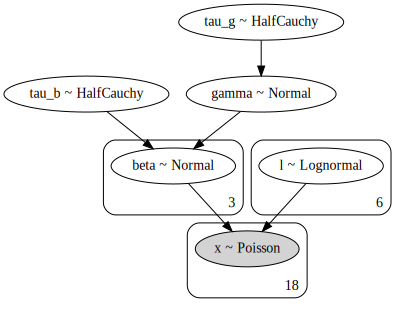

In [127]:
model_to_graphviz(model)

In [128]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, init="advi",
                        random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 167.03: 100%|██████████| 10000/10000 [00:04<00:00, 2486.66it/s]
Finished [100%]: Average Loss = 166.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [l, beta, tau_b, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:18<00:00, 665.53draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [129]:
az.effective_sample_size(trace).to_dataframe()

gamma    beta   tau_g  \
beta_dim_0 gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                          
0          0           0       0           0            907.0  7772.0  5080.0   
                       1       0           0            907.0  7772.0  5080.0   
                       2       0           0            907.0  7772.0  5080.0   
                       3       0           0            907.0  7772.0  5080.0   
                       4       0           0            907.0  7772.0  5080.0   
                       5       0           0            907.0  7772.0  5080.0   
1          0           0       0           0            907.0  7795.0  5080.0   
                       1       0           0            907.0  7795.0  5080.0   
                       2       0           0            907.0  7795.0  5080.0   
                       3       0           0            907.0  7795.0  5080.0   
                       4       0           0            907.0  7795.0  5080.0   
                       5       0           0            907.0  7795.0  5080.0   
2          0           0       0           0            907.0  4854.0  5080.0   
                       1       0           0            907.0  4854.0  5080.0   
                       2       0           0            907.0  4854.0  5080.0   
                       3       0           0            907.0  4854.0  5080.0   
                       4       0           0            907.0  4854.0  5080.0   
                       5       0           0            907.0  4854.0  5080.0   

                                                         tau_b       l  
beta_dim_0 gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                  
0          0           0       0           0            1220.0  7966.0  
                       1       0           0            1220.0  8110.0  
                       2       0           0            1220.0  8320.0  
                       3       0           0            1220.0  8109.0  
                       4       0           0            1220.0  5883.0  
                       5       0           0            1220.0  6200.0  
1          0           0       0           0            1220.0  7966.0  
                       1       0           0            1220.0  8110.0  
                       2       0           0            1220.0  8320.0  
                       3       0           0            1220.0  8109.0  
                       4       0           0            1220.0  5883.0  
                       5       0           0            1220.0  6200.0  
2          0           0       0           0            1220.0  7966.0  
                       1       0           0            1220.0  8110.0  
                       2       0           0            1220.0  8320.0  
                       3       0           0            1220.0  8109.0  
                       4       0           0            1220.0  5883.0  
                       5       0           0            1220.0  6200.0

In [130]:
az.rhat(trace).to_dataframe()

gamma  beta  tau_g  \
beta_dim_0 gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                       
0          0           0       0           0              1.0   1.0    1.0   
                       1       0           0              1.0   1.0    1.0   
                       2       0           0              1.0   1.0    1.0   
                       3       0           0              1.0   1.0    1.0   
                       4       0           0              1.0   1.0    1.0   
                       5       0           0              1.0   1.0    1.0   
1          0           0       0           0              1.0   1.0    1.0   
                       1       0           0              1.0   1.0    1.0   
                       2       0           0              1.0   1.0    1.0   
                       3       0           0              1.0   1.0    1.0   
                       4       0           0              1.0   1.0    1.0   
                       5       0           0              1.0   1.0    1.0   
2          0           0       0           0              1.0   1.0    1.0   
                       1       0           0              1.0   1.0    1.0   
                       2       0           0              1.0   1.0    1.0   
                       3       0           0              1.0   1.0    1.0   
                       4       0           0              1.0   1.0    1.0   
                       5       0           0              1.0   1.0    1.0   

                                                        tau_b    l  
beta_dim_0 gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0              
0          0           0       0           0              1.0  1.0  
                       1       0           0              1.0  1.0  
                       2       0           0              1.0  1.0  
                       3       0           0              1.0  1.0  
                       4       0           0              1.0  1.0  
                       5       0           0              1.0  1.0  
1          0           0       0           0              1.0  1.0  
                       1       0           0              1.0  1.0  
                       2       0           0              1.0  1.0  
                       3       0           0              1.0  1.0  
                       4       0           0              1.0  1.0  
                       5       0           0              1.0  1.0  
2          0           0       0           0              1.0  1.0  
                       1       0           0              1.0  1.0  
                       2       0           0              1.0  1.0  
                       3       0           0              1.0  1.0  
                       4       0           0              1.0  1.0  
                       5       0           0              1.0  1.0

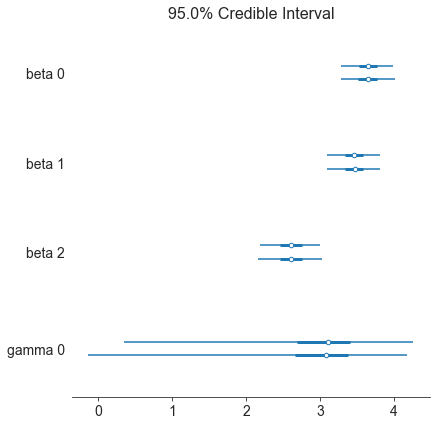

In [137]:
az.plot_forest(trace, credible_interval=0.95, var_names=["beta", "gamma"]);

## Non-centered

In [156]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=1)
    
    tau_b = pm.HalfCauchy('tau_b', 1, shape=1)        
    beta_non_center = pm.Normal('beta_non', 0, 1, shape=3)    
    beta = pm.Deterministic('beta', tau_b * beta_non_center + gamma[[0, 0, 0]])
    
    l = pm.Lognormal('l', 0, .25, shape = 3 * 2)
    x = pm.Poisson(        
        'x', 
        mu = np.exp(beta[beta_idx]) * l[l_idx] ,
        observed=counts)

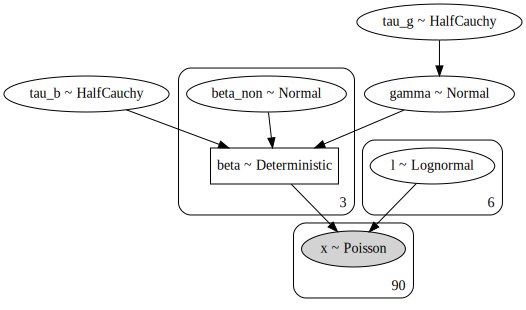

In [160]:
model_to_graphviz(model)

In [157]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, 
                      init="advi", random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 945.07: 100%|██████████| 10000/10000 [00:03<00:00, 2685.63it/s]   
Finished [100%]: Average Loss = 941.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [l, beta_non, tau_b, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:22<00:00, 144.60draws/s]
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [163]:
az.effective_sample_size(trace).to_dataframe().loc[0,0]

gamma  beta_non   tau_g  tau_b  \
gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                                   
0           0       0           0            490.0    1855.0  3106.0  608.0   
            1       0           0            490.0    1855.0  3106.0  608.0   
            2       0           0            490.0    1855.0  3106.0  608.0   
            3       0           0            490.0    1855.0  3106.0  608.0   
            4       0           0            490.0    1855.0  3106.0  608.0   
            5       0           0            490.0    1855.0  3106.0  608.0   

                                               beta       l  
gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                  
0           0       0           0            7021.0  7087.0  
            1       0           0            7021.0  7242.0  
            2       0           0            7021.0  7683.0  
            3       0           0            7021.0  7779.0  
            4       0           0            7021.0  7770.0  
            5       0           0            7021.0  7618.0

In [164]:
az.rhat(trace).to_dataframe().loc[0,0]

gamma  beta_non  tau_g  tau_b  \
gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0                                  
0           0       0           0              1.0       1.0    1.0    1.0   
            1       0           0              1.0       1.0    1.0    1.0   
            2       0           0              1.0       1.0    1.0    1.0   
            3       0           0              1.0       1.0    1.0    1.0   
            4       0           0              1.0       1.0    1.0    1.0   
            5       0           0              1.0       1.0    1.0    1.0   

                                             beta    l  
gamma_dim_0 l_dim_0 tau_b_dim_0 tau_g_dim_0             
0           0       0           0             1.0  1.0  
            1       0           0             1.0  1.0  
            2       0           0             1.0  1.0  
            3       0           0             1.0  1.0  
            4       0           0             1.0  1.0  
            5       0           0             1.0  1.0

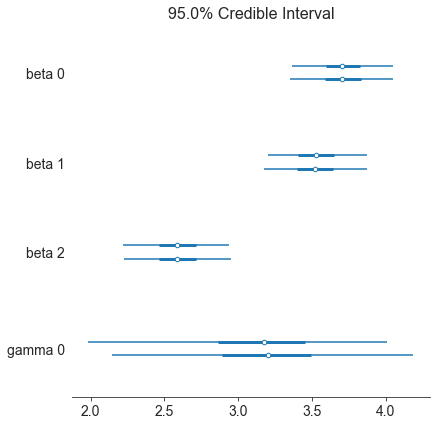

In [165]:
az.plot_forest(trace, credible_interval=0.95, var_names=["beta", "gamma"]);

In [166]:
beta_true

array([3.77603972, 3.34791345, 2.54054583])

In [168]:
gamma_true

4